In [52]:

import pandas as pd
import numpy as np
from unidecode import unidecode
from libpysal.weights.contiguity import Queen
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#df_f0=pd.read_excel("Bases//Base_Limpia.xlsx")

from scipy.stats import pearsonr, chi2_contingency

df_base_added=pd.read_csv("Bases//Base_Limpia_Added.csv")

In [53]:
df_f.columns

Index(['id', 'fnyear', 'sexo', 'edad', 'provincia_x', 'id_provincia',
       'departamento', 'id_departamento', 'localidad', 'fecha', 'resistencia',
       'embarazo_y_o_puerperio', 'diabetes', 'consumo_prob_drogas', 'etnia',
       'tabaquismo', 'alcoholismo', 'inicio_trat', 'fecha_fin_trat',
       'resultado_tratamiento', 'resultado_hiv', 'link', 'Provincia', 'salud',
       'poblacion_estimada', 'densidad_estimada', 'enfermedad respiratoria',
       'cod_prov', 'index obesity', 'provincia_y', 'departamen', 'valid_date',
       'Relative humidity', 'Specific humidity', 'Temperature', 'Temperature2',
       'RANGO_EDAD'],
      dtype='object')

In [54]:
df=df_f.copy()


df_aux=df_f.loc[(~df_f["fecha_fin_trat"].isnull())&(~df_f["fecha"].isnull())|((pd.to_datetime(df_f["fecha"])>"2022-05-01")&(df_f["fecha_fin_trat"].isnull()))]

df_aux=df_f.copy()


In [55]:
df_aux['fecha'] = pd.to_datetime(df_aux['fecha'])
df_aux['fecha_fin_trat'] = pd.to_datetime(df_aux['fecha_fin_trat'])

# Crear un rango de fechas que cubra todas las semanas
fechas_por_semana = pd.date_range(start=df_aux['fecha'].min(), end=df_aux['fecha_fin_trat'].max(), freq='W')

# Crear una columna para cada semana y provincia con la cantidad de casos activos
for semana_inicio in fechas_por_semana:
    semana_fin = semana_inicio + pd.Timedelta(days=6)
    semana_label = semana_inicio.strftime("%Y-%m-%d")
    
    df_aux[semana_label] = ((df_aux['fecha'] <= semana_fin) & (df_aux['fecha_fin_trat'] >= semana_inicio)).astype(int)
df_casos_activos_depto = pd.DataFrame(df_aux.groupby(['Provincia','departamento'])[fechas_por_semana.strftime('%Y-%m-%d')].sum().to_records())

fechas_mas=list(df_casos_activos_depto.columns[200:213])

df_casos_activos_depto_fecha=df_casos_activos_depto[['Provincia','departamento']+fechas_mas]


<h1>
<p style="font-weight: bold; text-align: center;background-color:#2E86C1">
<br>Inicio Análisis  </br>
<br></p></h1>



<h2>
<p style="font-weight: bold; text-align: center">
<br>Autocorrelación </br>
<br></p></h2>




In [56]:
import geopandas as gpd
from utils import utils
ruta_archivo_shp = 'Bases\\\Vecindad\\Codgeo_Pais_x_dpto_con_datos\\pxdptodatosok.shp'

# Abre el archivo SHP usando geopandas
dataframe_shp = gpd.read_file(ruta_archivo_shp)

dataframe_shp["provincia"]=dataframe_shp["provincia"].apply(utils.quitar_acentos_limpiar).str.replace("Ciudad Autonoma de Buenos Aires","Caba")



dataframe_shp["departamen"]=dataframe_shp["departamen"].apply(utils.quitar_acentos_limpiar)
dataframe_shp

,link,codpcia,departamen,provincia,mujeres,varones,personas,hogares,viv_part,viv_part_h,geometry
0,02001,02,Comuna 1,Caba,107789,98097,205886,84468,130771,78360,"POLYGON ((-58.37501 -34.57959, -58.36690 -34.5..."
1,02002,02,Comuna 2,Caba,89890,68042,157932,73156,107967,70869,"POLYGON ((-58.40084 -34.57126, -58.40005 -34.5..."
2,02003,02,Comuna 3,Caba,101936,85601,187537,80489,101161,75605,"POLYGON ((-58.39365 -34.60154, -58.39348 -34.6..."
3,02004,02,Comuna 4,Caba,115079,103166,218245,76455,82926,69680,"POLYGON ((-58.35695 -34.61980, -58.35672 -34.6..."
4,06091,06,Berazategui,Buenos Aires,165636,158608,324244,93164,96025,86248,"POLYGON ((-58.01702 -34.78120, -58.08380 -34.8..."
...,...,...,...,...,...,...,...,...,...,...,...
522,90112,90,Trancas,Tucuman,8478,8893,17371,4441,6889,4204,"POLYGON ((-65.54407 -26.09089, -65.54315 -26.0..."
523,90119,90,Yerba Buena,Tucuman,38500,36576,75076,18560,19691,17171,"POLYGON ((-65.25443 -26.78508, -65.25646 -26.7..."
524,94007,94,Rio Grande,Tierra del Fuego,34095,35947,70042,21410,23298,19790,"POLYGON ((-68.60577 -54.55123, -68.60480 -54.3..."
525,94014,94,Ushuaia,Tierra del Fuego,27826,29130,56956,17538,20054,16891,"MULTIPOLYGON (((-67.37727 -54.91089, -67.37819..."


In [57]:


df_deptos=df_f.copy()
df_deptos.loc[(df_deptos["departamento"]=="Desconocido")|(df_deptos["departamento"]=="Nan"),"departamento"]=np.nan
#df_deptos=df_deptos.loc[(df_deptos["Provincia"]=='Jujuy')&(~df_deptos["Departamento"].isnull())]
df_deptos=df_deptos.loc[(~df_deptos["departamento"].isnull())&((df_deptos["departamento"]!=""))]
df_deptos["departamento"]=df_deptos["departamento"].str.replace("Gral manuel belgrano","Dr. manuel belgrano")
df_deptos["AUX"]=1
df_deptos["departamento"].unique()


array(['Merlo', 'Almirante Brown', 'Avellaneda', 'Campana',
       'Esteban Echeverria', 'General San Martin', 'Hurlingham',
       'Jose C. Paz', 'La Matanza', 'Malvinas Argentinas', 'Moreno',
       'Moron', 'Pinamar', 'Quilmes', 'San Isidro', 'San Vicente',
       'Tres de Febrero', 'Vicente Lopez', 'Comuna 15', 'Bermejo',
       'Comandante Fernandez', 'Independencia', 'Mayor Luis J. Fontana',
       'Escalante', 'Futaleufu', 'Capital', 'Juarez Celman', 'Parana',
       'El Carmen', 'Rivadavia', 'Rosario de la Frontera', 'Rosario',
       'Cruz Alta', 'Lules', 'Ezeiza', 'Lomas de Zamora', 'Marcos Paz',
       'Comuna 1', 'Comuna 10', 'Comuna 11', 'Comuna 7', 'San Fernando',
       'Sargento Cabral', 'Biedma', 'Concordia', 'Formosa',
       'Lujan de Cuyo', 'General Jose de San Martin', 'Oran',
       'La Capital', 'Florencio Varela', 'Tandil', 'Tres Lomas',
       'Comuna 14', 'Comuna 3', 'Paso de Los Libres', 'Ramon Lista',
       'General Roca', '25 de Mayo', 'General Pueyrredon'

In [58]:


df_aux=pd.pivot_table(df_deptos,index=["Provincia","departamento"],values="AUX",aggfunc="sum")


df_aux2=pd.DataFrame(df_aux.to_records())
df_aux2.columns=["provincia","departamen","Infecciones"]
#df_jujuy2=pd.merge(df_jujuy_vecindad,df_aux2, left_index=True, right_index=True)[["departamen","Infecciones","geometry"]]

#dataframe_shp = gpd.read_file(ruta_archivo_shp)


In [59]:


ruta_archivo_shp = 'Bases\\\Vecindad\\Codgeo_Pais_x_dpto_con_datos\\pxdptodatosok.shp'

# Abre el archivo SHP usando geopandas
dataframe_shp = gpd.read_file(ruta_archivo_shp)

dataframe_shp["provincia"]=dataframe_shp["provincia"].apply(utils.quitar_acentos_limpiar).str.replace("Ciudad Autonoma de Buenos Aires","Caba")



dataframe_shp

,link,codpcia,departamen,provincia,mujeres,varones,personas,hogares,viv_part,viv_part_h,geometry
0,02001,02,Comuna 1,Caba,107789,98097,205886,84468,130771,78360,"POLYGON ((-58.37501 -34.57959, -58.36690 -34.5..."
1,02002,02,Comuna 2,Caba,89890,68042,157932,73156,107967,70869,"POLYGON ((-58.40084 -34.57126, -58.40005 -34.5..."
2,02003,02,Comuna 3,Caba,101936,85601,187537,80489,101161,75605,"POLYGON ((-58.39365 -34.60154, -58.39348 -34.6..."
3,02004,02,Comuna 4,Caba,115079,103166,218245,76455,82926,69680,"POLYGON ((-58.35695 -34.61980, -58.35672 -34.6..."
4,06091,06,Berazategui,Buenos Aires,165636,158608,324244,93164,96025,86248,"POLYGON ((-58.01702 -34.78120, -58.08380 -34.8..."
...,...,...,...,...,...,...,...,...,...,...,...
522,90112,90,Trancas,Tucuman,8478,8893,17371,4441,6889,4204,"POLYGON ((-65.54407 -26.09089, -65.54315 -26.0..."
523,90119,90,Yerba Buena,Tucuman,38500,36576,75076,18560,19691,17171,"POLYGON ((-65.25443 -26.78508, -65.25646 -26.7..."
524,94007,94,Río Grande,Tierra del Fuego,34095,35947,70042,21410,23298,19790,"POLYGON ((-68.60577 -54.55123, -68.60480 -54.3..."
525,94014,94,Ushuaia,Tierra del Fuego,27826,29130,56956,17538,20054,16891,"MULTIPOLYGON (((-67.37727 -54.91089, -67.37819..."


In [71]:
cases_dept=pd.DataFrame(pd.pivot_table(df_base_added,index=["link"],values="id",aggfunc="count").to_records())

dataframe_shp["link"]=dataframe_shp["link"].astype(int).astype(str)
cases_dept["link"]=cases_dept["link"].astype(str)

dataframe_shp[dataframe_shp["link"]=="6001"]

,link,codpcia,departamen,provincia,mujeres,varones,personas,hogares,viv_part,viv_part_h,geometry


In [76]:
cases_dept_area=pd.merge(dataframe_shp,cases_dept,on=["link"],how="right")
cases_dept_area=cases_dept_area.rename(columns={"id":"infecciones"})
cases_dept_area=cases_dept_area[~cases_dept_area["provincia"].isnull()]

In [135]:
from esda.moran import Moran
from esda.moran import Moran_Local
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
from splot.esda import lisa_cluster
from splot.esda import plot_local_autocorrelation
import libpysal
import esda

def autocorrelacion_plot(df_prov,solo_mapa=0):
    y = df_prov['infecciones'].values


    w = Queen.from_dataframe(df_prov)
    moran = esda.Moran_Local(y, w)


    lisa = esda.Moran_Local(y, w)

    # Añadir resultados LISA al GeoDataFrame
    df_prov['lisa_I'] = lisa.Is
    df_prov['lisa_p'] = lisa.p_sim
    df_prov['lisa_cluster'] = lisa.q

    # Determinar los clústeres HH
    df_prov['HH'] = np.where((df_prov['lisa_cluster'] == 1) & (df_prov['lisa_p'] <= 0.05), 1, 0)



    moran_loc = Moran_Local(y, w)
    if solo_mapa == 0:
        fig, ax = moran_scatterplot(moran_loc)
        ax.set_xlabel('infecciones')
        ax.set_ylabel('Spatial Lag of infecciones')
        plt.show()

        fig, ax = moran_scatterplot(moran_loc, p=0.05)
        display(moran_loc)
        ax.set_xlabel('infecciones')
        ax.set_ylabel('Spatial Lag of infecciones')
        plt.show()

    # Mostrar clústeres LISA en el mapa
    lisa_cluster(moran_loc, df_prov, p=0.05, figsize=(9, 9))
    plt.show()

    if solo_mapa == 0:
        plot_local_autocorrelation(moran_loc, df_prov, 'infecciones')
        plt.show()
    max_infections = moran_loc.Is.max()
    department_with_max_infections = df_prov.loc[df_prov['lisa_I'] == max_infections]

    print("Departamento con la mayor cantidad de infecciones:")
    print(department_with_max_infections)

    df_prov_subset = df_prov[df_prov['infecciones'] > 10]

    # Calcular el índice de Moran Local
    y = df_prov_subset['infecciones'].values
    w = Queen.from_dataframe(df_prov_subset)
    moran_loc = Moran_Local(y, w)

    # Añadir resultados de Moran Local al DataFrame
    df_prov_subset['moran_Is'] = moran_loc.Is
    df_prov_subset['moran_p_sim'] = moran_loc.p_sim
    df_prov_subset['moran_q'] = moran_loc.q
    if not gdf.crs.is_projected:
        gdf = gdf.to_crs(epsg=3395)


    # Mostrar gráfico de Moran scatterplot para el subset
    fig, ax = moran_scatterplot(moran_loc)
    ax.set_xlabel('infecciones')
    ax.set_ylabel('Spatial Lag of infecciones')
    plt.title('Moran Scatterplot para infecciones > 10')
    plt.show()
    return(df_prov)

In [136]:
df_casos_activos_depto_fecha2=df_casos_activos_depto_fecha.copy()

ANALISIS_FECHA=False
if ANALISIS_FECHA==True:
    col_fechas=df_casos_activos_depto_fecha2.columns
    l_fechas=len(col_fechas)
    for i in range(2,l_fechas):
        print(col_fechas[i])
        
        df_fecha=df_casos_activos_depto_fecha2[["Provincia","Departamento",col_fechas[i]]]
        df_fecha.columns=["provincia","departamen","infecciones"]
        df_mexclado3=pd.merge(dataframe_shp,df_fecha,on=["provincia","departamen"],how="left")
        df_mexclado3=df_mexclado3.loc[(df_mexclado3["provincia"]!="Desconocida")
        &(df_mexclado3["provincia"]!='Tierra del Fuego')]

        df_aux_vecindad=df_mexclado3.loc[(~df_mexclado3["codpcia"].isnull())][["departamen","infecciones","geometry"]] 
        df_aux_vecindad=df_aux_vecindad.fillna(0)
        autocorrelacion_plot(df_aux_vecindad,solo_mapa=1)

In [137]:

ANALISIS_TOP=False
if ANALISIS_TOP==True:
    for t in cases_dept_area["provincia"].unique():
        if t!="Desconocida" and t!="Tierra del Fuego":
            t=unidecode(str(t))
            print(t)
            df_aux_vecindad=cases_dept_area.loc[(cases_dept_area["provincia"]==t)&(~cases_dept_area["codpcia"].isnull())].reset_index(drop=True)[["departamen","infecciones","geometry"]] 

            autocorrelacion_plot(df_aux_vecindad,solo_mapa=1)



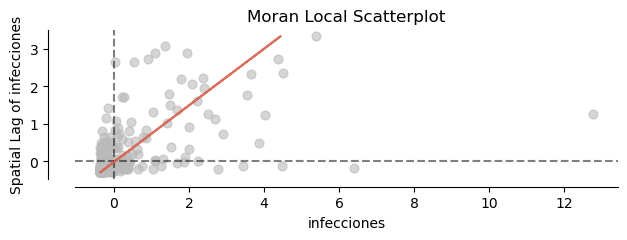

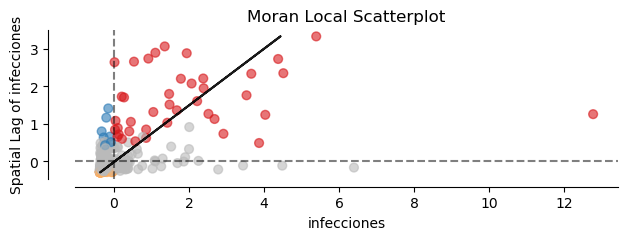

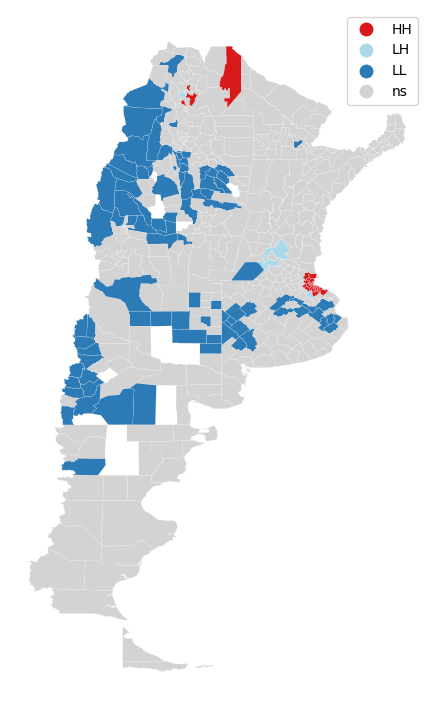

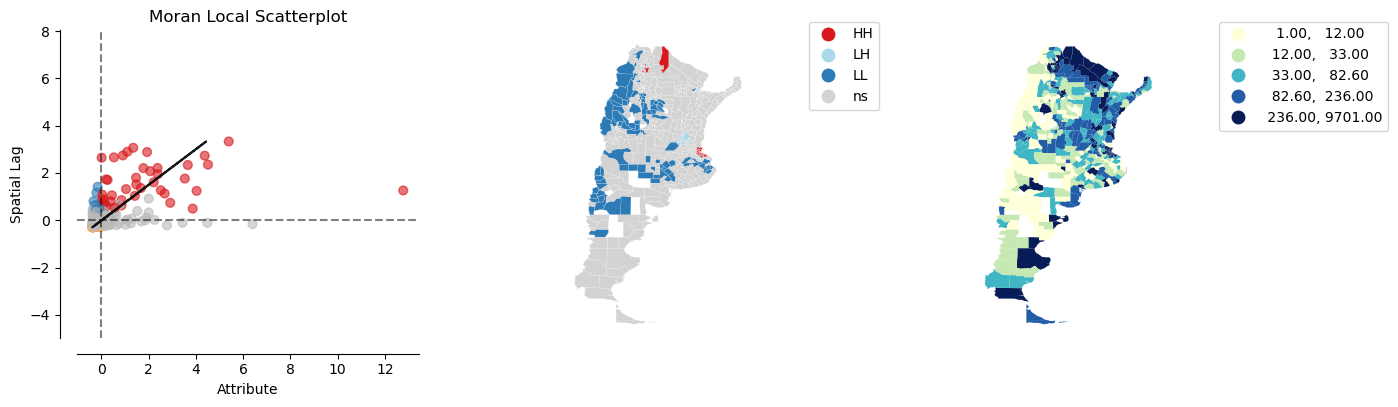

Departamento con la mayor cantidad de infecciones:
       provincia       departamen  infecciones  \
91  Buenos Aires  Lomas de Zamora         4255   

                                             geometry     lisa_I  lisa_p  \
91  POLYGON ((-58.46128 -34.70617, -58.46116 -34.7...  23.874731   0.001   

    lisa_cluster  HH  
91             1   1  
('WARNING: ', 303, ' is an island (no neighbors)')
('WARNING: ', 312, ' is an island (no neighbors)')


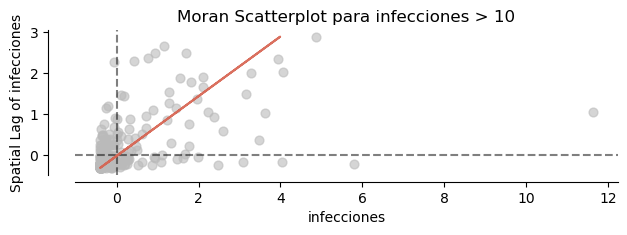

In [138]:
df_lisa=autocorrelacion_plot(cases_dept_area[["provincia","departamen","infecciones","geometry"]])

In [139]:
df_lisa.sort_values(by="infecciones",ascending=False)[:30]

,provincia,departamen,infecciones,geometry,lisa_I,lisa_p,lisa_cluster,HH
82,Buenos Aires,La Matanza,9701,"POLYGON ((-58.52885 -34.65516, -58.52847 -34.6...",21.526872,0.001,1,1
462,Santa Fe,Rosario,4997,"POLYGON ((-60.69614 -32.83999, -60.69611 -32.8...",-1.272938,0.466,4,0
91,Buenos Aires,Lomas de Zamora,4255,"POLYGON ((-58.46128 -34.70617, -58.46116 -34.7...",23.874731,0.001,1,1
118,Buenos Aires,Quilmes,3608,"POLYGON ((-58.33361 -34.72800, -58.33303 -34.7...",14.129502,0.001,1,1
396,Salta,Capital,3587,"POLYGON ((-65.58015 -24.65886, -65.57784 -24.6...",-0.588451,0.488,4,0
99,Buenos Aires,Merlo,3506,"POLYGON ((-58.72917 -34.63584, -58.72889 -34.6...",15.890402,0.001,1,1
102,Buenos Aires,Moreno,3253,"POLYGON ((-58.82401 -34.50921, -58.82374 -34.5...",6.701878,0.015,1,1
84,Buenos Aires,La Plata,3131,"MULTIPOLYGON (((-58.08492 -34.83709, -58.08289...",2.580736,0.061,1,0
21,Buenos Aires,Almirante Brown,2978,"POLYGON ((-58.31264 -34.87587, -58.32095 -34.8...",11.385891,0.003,1,1
57,Buenos Aires,Florencio Varela,2884,"POLYGON ((-58.31264 -34.87587, -58.31464 -34.8...",8.304198,0.003,1,1
